In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
from utils.pandas import apply_filters
from utils_local import read_spreadsheet, colors_v1, markers_v1

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Domain-shift: Linear and Finetuning

In [5]:
from utils_local import load_domain_shift_results, scatter_with_correlation

In [6]:
k400_values, df_linear, df_finetune = load_domain_shift_results(remove_K400=True)

In [7]:
k400_values

{'Method': ['None',
  'MoCo',
  'SeLaVi',
  'VideoMoCo',
  'Pretext-contrast',
  'RSPNet',
  'AVID-CMA',
  'CTP',
  'TCLR',
  'GDT',
  'Supervised'],
 'linear': array([ 0.  , 36.24, 24.05, 30.99, 22.35, 42.84, 43.49,  7.61, 19.84,
        38.61,  0.  ])}

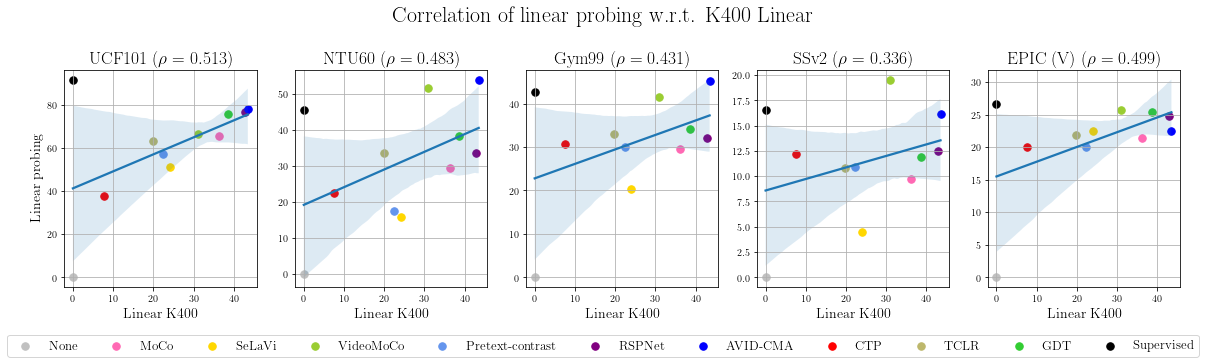

In [8]:
fig, axes = plt.subplots(1, len(df_linear.columns), figsize=(20, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = df_linear.columns[i]
    
    ylabel = "Linear probing" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df_linear.index),
        loc='lower center',
        bbox_to_anchor=(-2, -0.35),
        fontsize=13,
    )
    
    scatter_with_correlation(
        xvalues=k400_values["linear"],
        yvalues=df_linear[dataset].values,
        labels=df_linear.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        xlabel="Linear K400",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()

plt.suptitle("Correlation of linear probing w.r.t. K400 Linear", fontsize=22, y=1.1)
plt.show()

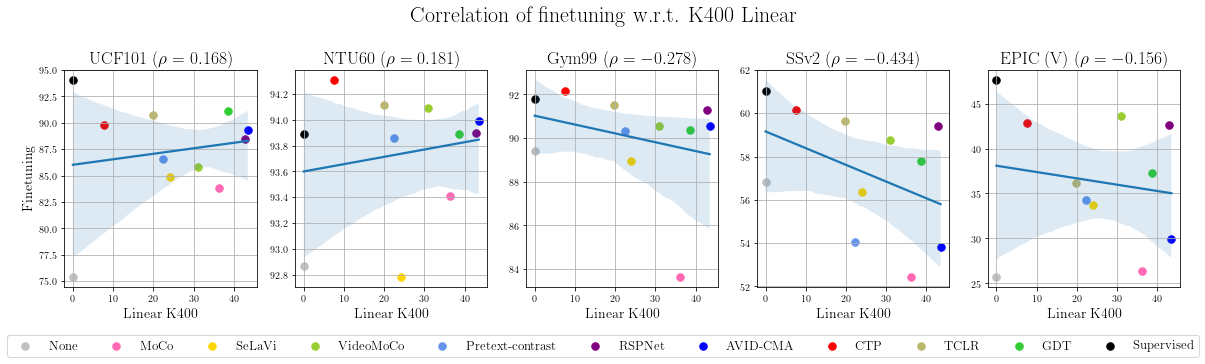

In [9]:
fig, axes = plt.subplots(1, len(df_finetune.columns), figsize=(20, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = df_finetune.columns[i]
    
    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df_linear.index),
        loc='lower center',
        bbox_to_anchor=(-2, -0.35),
        fontsize=13,
    )
    
    scatter_with_correlation(
        xvalues=k400_values["linear"],
        yvalues=df_finetune[dataset].values,
        labels=df_finetune.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        xlabel="Linear K400",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()

plt.suptitle("Correlation of finetuning w.r.t. K400 Linear", fontsize=22, y=1.1)
plt.show()

#### Correlation with UCF performance

In [11]:
df_finetune

,UCF101,NTU60,Gym99,SSv2,EPIC (V)
None,75.36,92.87,89.41,56.81,25.67
MoCo,83.80,93.41,83.62,52.42,26.40
SeLaVi,84.88,92.78,88.93,56.37,33.77
VideoMoCo,85.83,94.09,90.54,58.75,43.61
Pretext-contrast,86.60,93.86,90.31,54.03,34.29
RSPNet,88.47,93.90,91.28,59.39,42.67
AVID-CMA,89.33,93.99,90.56,53.82,29.91
CTP,89.77,94.31,92.17,60.16,42.84
TCLR,90.77,94.11,91.49,59.64,36.18
GDT,91.14,93.89,90.36,57.78,37.26


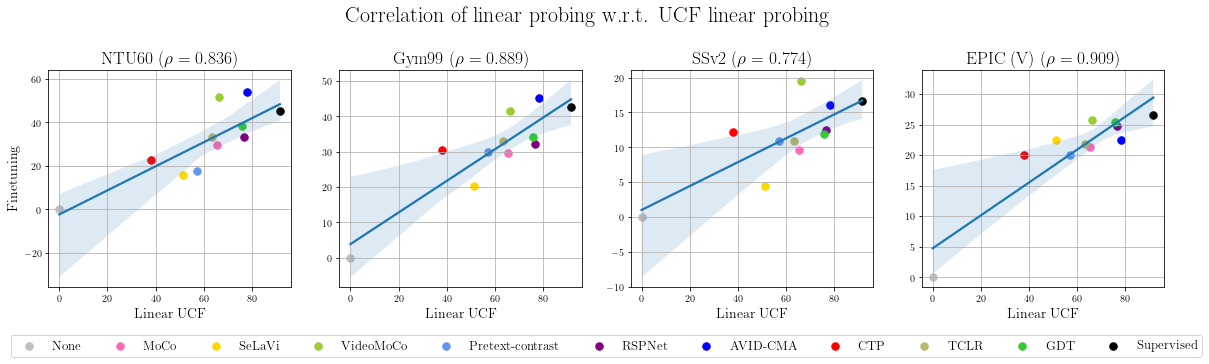

In [29]:
datasets = [x for x in df_linear.columns if "UCF" not in x]

fig, axes = plt.subplots(1, len(datasets), figsize=(20, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = datasets[i]
    
    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df_linear.index),
        loc='lower center',
        bbox_to_anchor=(-1.3, -0.35),
        fontsize=13,
    )
    
    scatter_with_correlation(
        xvalues=df_linear["UCF101"].values,
        yvalues=df_linear[dataset].values,
        labels=df_linear.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        xlabel="Linear UCF",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()

plt.suptitle("Correlation of linear probing w.r.t. UCF linear probing", fontsize=22, y=1.1)
plt.show()

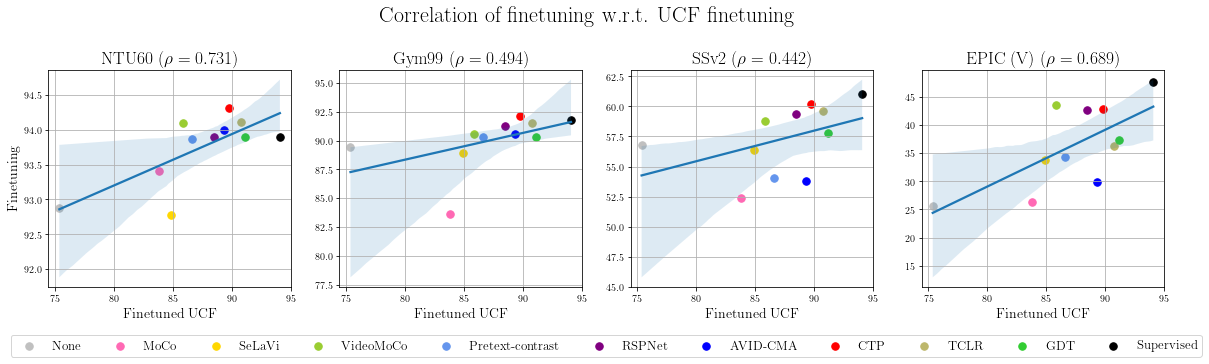

In [30]:
datasets = [x for x in df_linear.columns if "UCF" not in x]

fig, axes = plt.subplots(1, len(datasets), figsize=(20, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = datasets[i]
    
    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df_finetune.index),
        loc='lower center',
        bbox_to_anchor=(-1.3, -0.35),
        fontsize=13,
    )
    
    scatter_with_correlation(
        xvalues=df_finetune["UCF101"].values,
        yvalues=df_finetune[dataset].values,
        labels=df_finetune.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        xlabel="Finetuned UCF",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()

plt.suptitle("Correlation of finetuning w.r.t. UCF finetuning", fontsize=22, y=1.1)
plt.show()

### Domain-shift with varying training data size

In [93]:
df = read_spreadsheet(gid_key="dataset_size")
df.dropna(inplace=True)

In [94]:
dataset_full_size = {
    "UCF": "9500",
    "NTU": "40300",
    "Gym99": "20500",
    "SS": "169000",
}

In [95]:
for d, v in dataset_full_size.items():
    indices = (df.Dataset == d) * (df["Dataset size"] == "Full")
    df.at[indices, "Dataset size (float)"] = v

In [96]:
df["Dataset size (float)"] = df["Dataset size (float)"].astype(float)

In [98]:
df_ucf = apply_filters(df, {"Dataset": "UCF"})

In [100]:
k400_values

{'linear': array([ 0.  , 36.24, 24.05, 30.99, 22.35, 42.84, 43.49,  7.61, 19.84,
        38.61,  0.  ])}

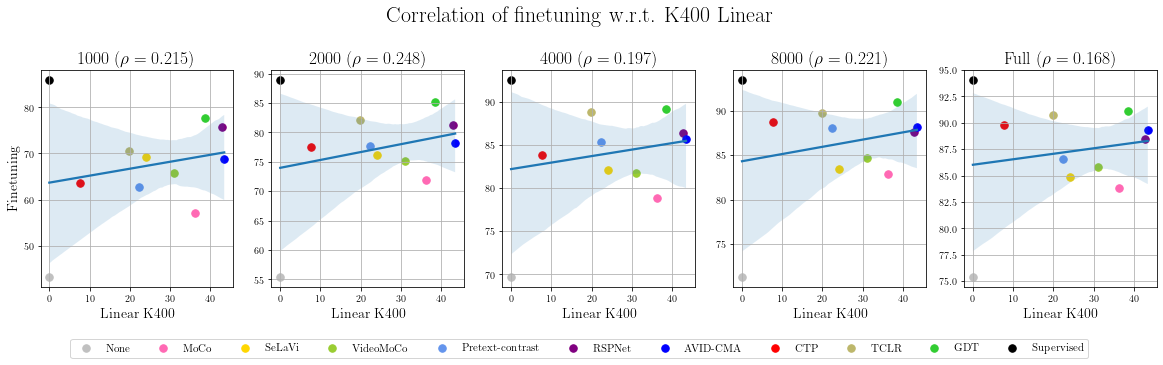

In [180]:
sizes = df_ucf["Dataset size"].unique()

fig, axes = plt.subplots(1, len(sizes), figsize=(20, 4))


for i, size in enumerate(sizes):
    sdf = apply_filters(df_ucf, {"Dataset size": size})

    # reorder based on UCF finetuning performance
    sdf = sdf.set_index("Method").rename(index={
        "No pretraining": "None",
        "Supervised pretraining": "Supervised",
        "SELAVI": "SeLaVi",
        "RSPNET": "RSPNet",
        "Video Moco": "VideoMoCo",
        "Pretext-Contrast": "Pretext-contrast",
    }).loc[np.array(k400_values["Method"])].reset_index()

    methods = sdf.Method.values

    ax = axes[i]
    
    dataset = df_finetune.columns[i]
    
    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(methods),
        loc='lower center',
        bbox_to_anchor=(-2, -0.35),
        fontsize=11,
    )
    
    scatter_with_correlation(
        xvalues=k400_values["linear"],
        yvalues=sdf["Top-1"].values,
        labels=methods,
        ax=ax,
        size_alpha=0.7,
        title=size,
        xlabel="Linear K400",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()


plt.suptitle("Correlation of finetuning w.r.t. K400 Linear", fontsize=22, y=1.1)
plt.show()

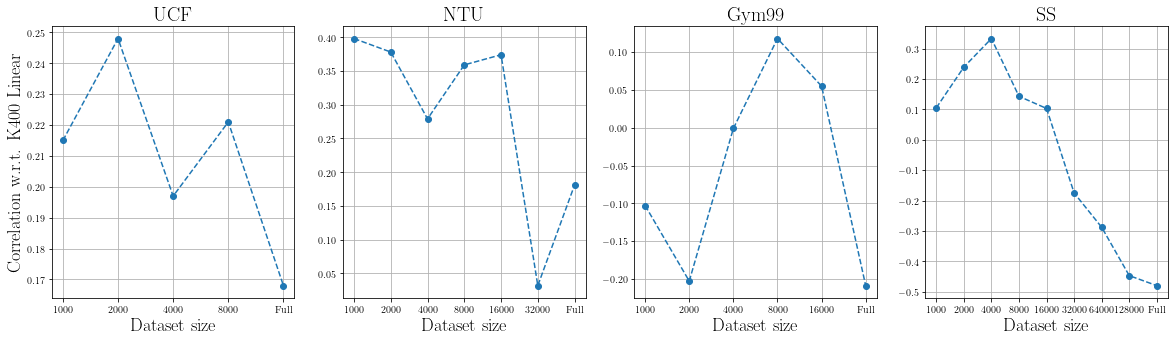

In [182]:
datasets = df.Dataset.unique()

fig, axes = plt.subplots(1, len(datasets), figsize=(20, 5))


ax.grid()
ax.set_title("Correlation between K400 linear vs finetuning", fontsize=20)


for i, dataset in enumerate(datasets):
    
    ax = axes[i]

    sizes_to_plot = []
    correlations = []
    
    df_dataset = apply_filters(df, {"Dataset": dataset})
    sizes = df_dataset["Dataset size"].unique()


    xvalues = k400_values["linear"]
    for j, size in enumerate(sizes):
        sdf = apply_filters(df_dataset, {"Dataset size": size})
        # reorder based on UCF finetuning performance
        sdf = sdf.set_index("Method").rename(index={
            "No pretraining": "None",
            "Supervised pretraining": "Supervised",
            "SELAVI": "SeLaVi",
            "RSPNET": "RSPNet",
            "Video Moco": "VideoMoCo",
            "Pretext-Contrast": "Pretext-contrast",
        }).loc[np.array(k400_values["Method"])].reset_index()
        

        methods = sdf.Method.values

        yvalues = sdf["Top-1"].values

        corr = np.round(np.corrcoef(xvalues, yvalues)[0, 1], decimals=3)
        # corr = stats.spearmanr(xvalues, yvalues).correlation
        sizes_to_plot.append(size)
        correlations.append(corr)
    
    # ax.set_ylim(-0.5, 0.6)
    ax.plot(sizes_to_plot, correlations, "--o", label=dataset)
    ax.set_title(dataset, fontsize=20)
    ax.grid()
    ax.set_xlabel("Dataset size", fontsize=18)

    if i == 0:
        ax.set_ylabel("Correlation w.r.t. K400 Linear", fontsize=18)

plt.show()

### Correlation plots for `FineGym`

In [37]:
from utils_local import load_finegym_results

In [38]:
df = load_finegym_results()

In [39]:
df

,Method,Gym99 (99) (video),Gym99 (99) (class),Gym288 (288) (video),Gym288 (288) (class),Vault (6) (video),Vault (6) (class),FX (35) (video),FX (35) (class),FX-S1 (11) (video),FX-S1 (11) (class),UB-S1 (15) (video),UB-S1 (15) (class)
0,None,89.41,84.40,84.71,50.01,41.26,24.67,79.16,75.88,50.32,44.98,88.44,83.98
1,MoCo,89.41,83.62,85.05,51.65,43.95,32.10,85.76,82.95,70.27,62.21,88.85,84.14
2,SeLaVi,88.93,84.75,83.68,52.82,43.72,25.44,80.01,76.04,57.92,50.15,85.11,81.46
3,VideoMoCo,90.54,86.36,85.31,54.07,45.74,27.78,84.19,79.52,68.60,60.39,87.90,82.07
4,Pretext-contrast,90.31,85.70,85.42,52.66,46.19,28.48,84.68,81.37,72.84,65.78,90.62,86.24
5,RSPNet,91.28,87.59,86.11,55.20,43.72,33.35,85.40,82.72,71.30,63.50,89.06,85.12
6,AVID-CMA,90.56,85.83,85.96,52.46,45.52,30.35,85.98,82.65,75.29,67.15,92.45,88.41
7,CTP,92.17,88.33,87.33,56.51,44.17,26.83,88.99,86.16,84.68,79.66,92.32,88.44
8,TCLR,91.49,87.97,86.93,55.37,46.19,29.84,87.38,84.25,69.63,61.02,90.48,85.29
9,GDT,90.36,86.46,85.74,55.36,44.62,33.11,85.80,83.64,72.84,65.72,88.17,81.62


In [42]:
# extract per-class results
df_class = df[[x for x in df.columns if "class" in x or "Method" in x]]
df_class = df_class.set_index(keys=["Method"])
df_class.columns = [x.replace(" (class)", "") for x in df_class.columns]

In [43]:
df_class

,Gym99 (99),Gym288 (288),Vault (6),FX (35),FX-S1 (11),UB-S1 (15)
Method,,,,,,
None,84.40,50.01,24.67,75.88,44.98,83.98
MoCo,83.62,51.65,32.10,82.95,62.21,84.14
SeLaVi,84.75,52.82,25.44,76.04,50.15,81.46
VideoMoCo,86.36,54.07,27.78,79.52,60.39,82.07
Pretext-contrast,85.70,52.66,28.48,81.37,65.78,86.24
RSPNet,87.59,55.20,33.35,82.72,63.50,85.12
AVID-CMA,85.83,52.46,30.35,82.65,67.15,88.41
CTP,88.33,56.51,26.83,86.16,79.66,88.44
TCLR,87.97,55.37,29.84,84.25,61.02,85.29


In [45]:
datasets

['Gym288 (288)', 'Vault (6)', 'FX (35)', 'FX-S1 (11)', 'UB-S1 (15)']

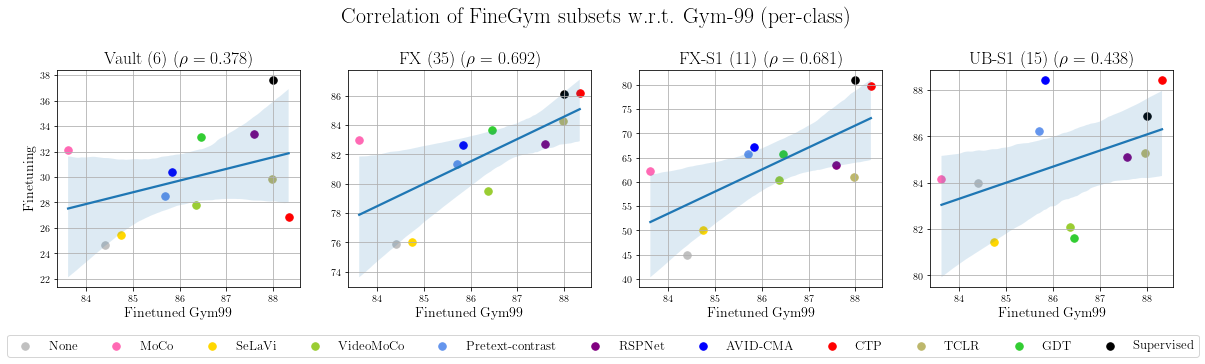

In [61]:
datasets = [x for x in df_class.columns if not ("Gym99" in x)]
datasets = [x for x in df_class.columns if not ("Gym99" in x or "Gym288" in x)]
legend_xloc = -2.0 if len(datasets) == 5 else -1.35

fig, axes = plt.subplots(1, len(datasets), figsize=(20, 4))

for i in range(len(axes)):
    ax = axes[i]
    
    dataset = datasets[i]

    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df_class.index),
        loc='lower center',
        bbox_to_anchor=(legend_xloc, -0.35),
        fontsize=13,
    )
    
    scatter_with_correlation(
        xvalues=df_class["Gym99 (99)"].values,
        yvalues=df_class[dataset].values,
        labels=df_class.index,
        ax=ax,
        size_alpha=0.7,
        title=dataset,
        xlabel="Finetuned Gym99",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()

plt.suptitle("Correlation of FineGym subsets w.r.t. Gym-99 (per-class)", fontsize=22, y=1.1)
plt.show()

### Task shift

In [74]:
df = read_spreadsheet(gid_key="task_shift_ucf")

# consider complement on Repetition
complement_repetition = True
if complement_repetition:
    df["Repetition (MAE)"] = 1 - df["Repetition (MAE)"]
    # df["Repetition (1 - MAE)"] = df["Repetition (MAE)"]
    df.rename(columns={"Repetition (MAE)": "Repetition (1 - MAE)"}, inplace=True)

# order by Action recognition
df.sort_values("Action recognition (Top-1)", inplace=True)

# reorder tasks
correct_order = ["Method", "Action recognition (Top-1)", "Spatio-temporal (IoU@0.5)", "Repetition (1 - MAE)", "AoT (Top-1)"]
df = df[correct_order]

# specific change
df.loc[9, "Method"] = "Supervised"

# set index
df.set_index("Method", inplace=True)

In [75]:
df

,Action recognition (Top-1),Spatio-temporal (IoU@0.5),Repetition (1 - MAE),AoT (Top-1)
Method,,,,
No pretraining,75.36,0.3273,0.7680,56.106
Video Moco,85.59,0.4374,0.8241,72.905
Pretext-Contrast,85.83,0.4619,0.8315,77.227
Selavi,86.60,0.4192,0.8488,77.439
RSPNET,88.47,0.4401,0.8400,86.955
AVID-CMA,89.33,0.4354,0.8381,83.254
TCLR,89.77,0.4764,0.8507,85.633
CTP,90.77,0.4646,0.8217,77.055
GDT,91.14,0.4629,0.8633,76.368


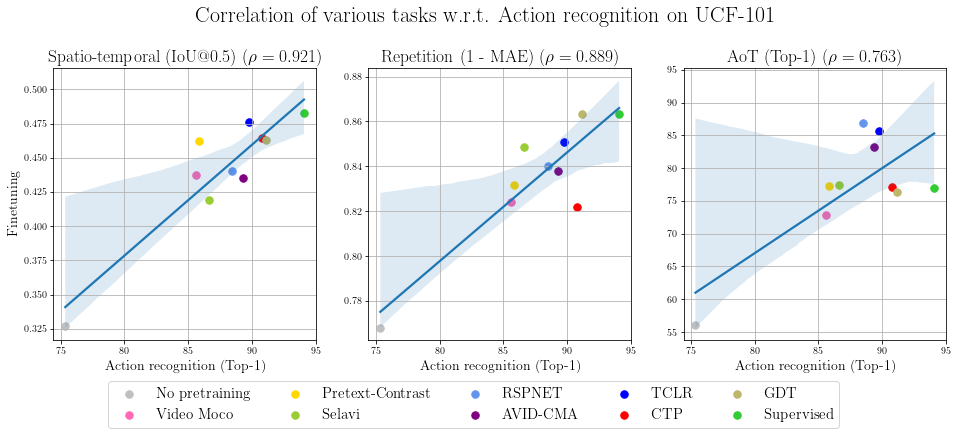

In [88]:
tasks = [x for x in df.columns if not ("Action recognition" in x)]
# legend_xloc = -2.0 if len(datasets) == 5 else -1.35
legend_xloc = -0.8

fig, axes = plt.subplots(1, len(tasks), figsize=(16, 5))

for i in range(len(axes)):
    ax = axes[i]
    
    task = tasks[i]

    ylabel = "Finetuning" if i == 0 else ""
    legend = True if i == len(axes) - 1 else False
    legend_kwargs = dict(
        ncol=len(df.index) // 2,
        loc='lower center',
        bbox_to_anchor=(legend_xloc, -0.35),
        fontsize=15,
    )
    
    scatter_with_correlation(
        xvalues=df["Action recognition (Top-1)"].values,
        yvalues=df[task].values,
        labels=df.index,
        ax=ax,
        size_alpha=0.7,
        title=task,
        xlabel="Action recognition (Top-1)",
        ylabel=ylabel,
        legend=legend,
        legend_kwargs=legend_kwargs,
    )
    ax.grid()

plt.suptitle("Correlation of various tasks w.r.t. Action recognition on UCF-101", fontsize=22, y=1.05)
plt.show()